# Import libs

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import altair as alt
from scipy.signal import deconvolve

In [2]:
def extract_data(test_subjects):
    df_datas = {}
    for test_subject in test_subjects:
        # read data from the text file
        df = pd.read_csv(f"./sesi 2 (13.00-15.00)/{test_subject}.txt", sep="\t", header=None)
        # extract XRF data
        df_data = df.iloc[12:]
        df_data.columns = ["x", "y"]
        df_data = df_data.astype(float)
        df_datas[test_subject] = df_data
    return df_datas

In [3]:
def plot_data(df_data, title, width=800, height=400, prominence=400):
    """
    Plots data using Altair with interactive tooltips, custom dimensions, and marked peaks,
    accounting for noise using scipy.signal.find_peaks.

    Args:
        df_data (pd.DataFrame): DataFrame with 'x' and 'y' columns.
        title (str): Title of the plot.
        width (int): Width of the chart.
        height (int): Height of the chart.
        prominence (int): Minimum prominence of peaks to be detected. Adjust this value to filter out noise.
    """
    df_data['x'] = pd.to_numeric(df_data['x'], errors='coerce')
    df_data['y'] = pd.to_numeric(df_data['y'], errors='coerce')
    df_data = df_data.dropna()

    y_values = df_data['y'].values
    x_values = df_data['x'].values

    peaks, _ = find_peaks(y_values, prominence=prominence)

    peak_df = pd.DataFrame({'x': x_values[peaks], 'y': y_values[peaks]})

    base_chart = alt.Chart(df_data).mark_line().encode(
        x=alt.X('x', title='KeV'),
        y=alt.Y('y', title='Counts/s'),
        tooltip=['x', 'y']
    ).properties(
        title=title,
        width=width,
        height=height
    ).interactive()

    peaks_chart = alt.Chart(peak_df).mark_point(color='red', size=50).encode(
        x='x',
        y='y',
        tooltip=['x', 'y']
    )
    final_chart = base_chart + peaks_chart

    final_chart.show()

# Plot data

In [4]:
test_subjects = ["bodrex","Entrostop","Koin 1000","mylanta"]
df_datas = extract_data(test_subjects)

In [5]:
plot_data(df_datas["bodrex"], "Hasil XRF Bodrex", width=1000, height=600, prominence=400)

alt.LayerChart(...)

In [6]:
plot_data(df_datas["Entrostop"], "Hasil XRF Entrostop", width=1000, height=600, prominence=400)

alt.LayerChart(...)

In [7]:
plot_data(df_datas["Koin 1000"], "Hasil XRF Koin 1000", width=1000, height=600, prominence=400)

alt.LayerChart(...)

In [8]:
plot_data(df_datas["mylanta"], "Hasil XRF Mylanta", width=1000, height=600, prominence=400)

alt.LayerChart(...)

# Deconvolution (idk what am doing we're moving to origin)

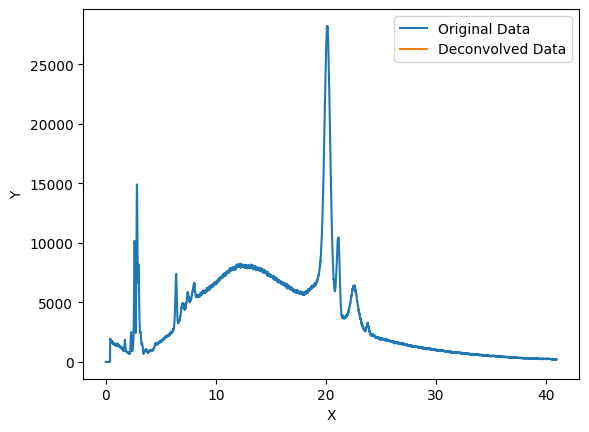

In [9]:
# Load data from the file
# data = np.loadtxt('./sesi 2 (13.00-15.00)/bodrex.txt', skiprows=13)  # Skip the header rows

# # Separate x and y data
# x = data[:, 0]
# y = data[:, 1]


# Define a Gaussian function to represent the instrumental broadening
def gaussian(x, mu, sigma):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

# Assume the instrumental broadening is a Gaussian with sigma = 0.1
instrument_broadening = gaussian(df_datas["bodrex"]["x"], 0, 0.1)

# Deconvolve the data
deconvolved, remainder = deconvolve(df_datas["bodrex"]["y"], instrument_broadening)

# Plot the original and deconvolved data
plt.plot(df_datas["bodrex"]["x"], df_datas["bodrex"]["y"], label='Original Data')
plt.plot(df_datas["bodrex"]["x"][:len(deconvolved)], deconvolved, label='Deconvolved Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener

# Load data from the file
# data = np.loadtxt('bodrex.txt', skiprows=13)

# Separate x and y data
x = df_datas["bodrex"]["x"]
y = df_datas["bodrex"]["y"]

def gaussian(x, mu, sigma):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

# Smooth the data using a Gaussian filter
window_length = int(11)
sigma = 2
smoothed_y = gaussian(np.arange(window_length), window_length // 2, sigma)
smoothed_y /= smoothed_y.sum()
smoothed_data = np.convolve(y, smoothed_y, mode='same')

# Apply Wiener deconvolution
psf_width = int(5)
psf = gaussian(np.arange(psf_width), psf_width // 2, 1)
psf /= psf.sum()
deconvolved_wiener = wiener(smoothed_data, psf, noise=np.std(smoothed_data)/2)

# Plot the original and deconvolved data
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Original Data', alpha=0.5)
plt.plot(x, smoothed_data, label='Smoothed Data', alpha=0.7)
plt.plot(x, deconvolved_wiener, label='Deconvolved Data (Wiener)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Deconvolution using Wiener Filter')
plt.grid(True)
plt.show()

TypeError: 'numpy.float64' object cannot be interpreted as an integer